# Railway Flow Visualization by Country

This notebook visualizes railway flows (IWW) for a user-selected country using:
- Train stations and railways dataframes 
- OD (Origin-Destination) matrices
- IWW network (edges and nodes)
- Country boundaries

It assigns independently passenger and freight flows, assuming a max capacity per rail line based on the number of operable hours per each train typology.

**Output:** Maps showing flows going through each railway, zoomed to the selected country.

## 1. Imports and Configuration

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import warnings
from pathlib import Path
import os
from collections import defaultdict, deque
from itertools import chain
import matplotlib.lines as mlines
import sys

sys.path.append(str(Path().resolve().parent))

from utils.miraca_flow_utils import compute_travel_time_kh, pick_col, map_stations_to_nodes, compute_edge_capacity, ensure_series, find_minimal_flows_along_overcapacity_paths, get_path_indexes_for_edges, od_flow_allocation_capacity_constrained
from utils.miraca_flow_utils import get_flow_paths_indexes_of_edges, get_flow_on_edges, update_flow_and_overcapacity, create_igraph_from_dataframe, network_od_path_estimations_multiattribute, network_od_paths_assembly_multiattributes
from utils.miraca_flow_utils import plot_edges_by_flow_thickness

warnings.filterwarnings('ignore')

base_path = Path(os.path.dirname(os.getcwd()) + "/data")
outpath = Path(os.path.dirname(os.getcwd()) + "/output")

# Load country boundaries
countries_gdf = gpd.read_file(base_path / "helpers" / "ne_10m_admin_0_countries.shp")

# Ensure CRS is WGS84
if countries_gdf.crs is None:
    countries_gdf = countries_gdf.set_crs(4326)
elif countries_gdf.crs.to_epsg() != 4326:
    countries_gdf = countries_gdf.to_crs(4326)

# Filter to Europe region
europe_bounds = {"xmin": -12, "xmax": 32, "ymin": 35, "ymax": 72}
europe_countries = countries_gdf.cx[
    europe_bounds["xmin"]:europe_bounds["xmax"], 
    europe_bounds["ymin"]:europe_bounds["ymax"]
].copy()

print(f"Loaded {len(europe_countries)} countries in Europe region")

Loaded 54 countries in Europe region


## 2. Load data and prepare OD matrices

In [2]:
print('Loading rail data...')
edges_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_railway_edges.parquet").to_crs("EPSG:4326")
nodes_gdf = gpd.read_parquet(base_path / "Infra_BE/belgium_railway_nodes.parquet").to_crs("EPSG:4326")
stations_df = gpd.read_parquet(base_path / "Infra_BE/belgium_railway_stations.parquet").to_crs("EPSG:4326")
od_flows_pass = pd.read_parquet(base_path / "ODs_BE/belgium_rail_passenger_OD.parquet")
od_flows_freight = pd.read_parquet(base_path / "ODs_BE/belgium_rail_freight_OD.parquet")

if edges_gdf.crs is None: edges_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
if nodes_gdf.crs is None: nodes_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
print('Data loaded.')

edges_gdf = compute_travel_time_kh(edges_gdf, speed_col='tag_maxspeed')
edge_src = pick_col(edges_gdf, ['from_id'])
edge_dst = pick_col(edges_gdf, ['to_id'])
node_id_col = pick_col(nodes_gdf, ['id'])
station_id_col = pick_col(stations_df, ['id'])


# Prepare OD data
od_pass = od_flows_pass.copy()
od_freight = od_flows_freight.copy()
od_pass['from_node'] = od_pass['origin_node'].astype(str)
od_pass['to_node']   = od_pass['dest_node'].astype(str)
od_pass = od_pass.dropna(subset=['from_node','to_node'])
od_pass['from_node'] = od_pass['from_node'].astype(str)
od_pass['to_node']   = od_pass['to_node'].astype(str)
od_pass['trips']     = pd.to_numeric(od_pass['trips'], errors='coerce').fillna(0.0)
# Drop original node columns to avoid confusion
od_pass = od_pass.drop(columns=['origin_node', 'dest_node'], errors='ignore')
od_pass = od_pass[od_pass['trips'] > 0]

od_freight['from_node'] = od_freight['from_id'].astype(str)
od_freight['to_node']   = od_freight['to_id'].astype(str)
od_freight = od_freight.dropna(subset=['from_node','to_node'])
od_freight['from_node'] = od_freight['from_node'].astype(str)
od_freight['to_node']   = od_freight['to_node'].astype(str)
od_freight['ths_tons']     = pd.to_numeric(od_freight['value'], errors='coerce').fillna(0.0)
od_freight = od_freight[od_freight['ths_tons'] > 0]

Loading rail data...
Data loaded.


## 3. Compute Capacities and plot them

- Assign stable `edge_id` and build `network_df`
- Estimate per-edge capacities (trains/day and passengers/day)
- Save capacity parquet and plot by rail class plus combined map

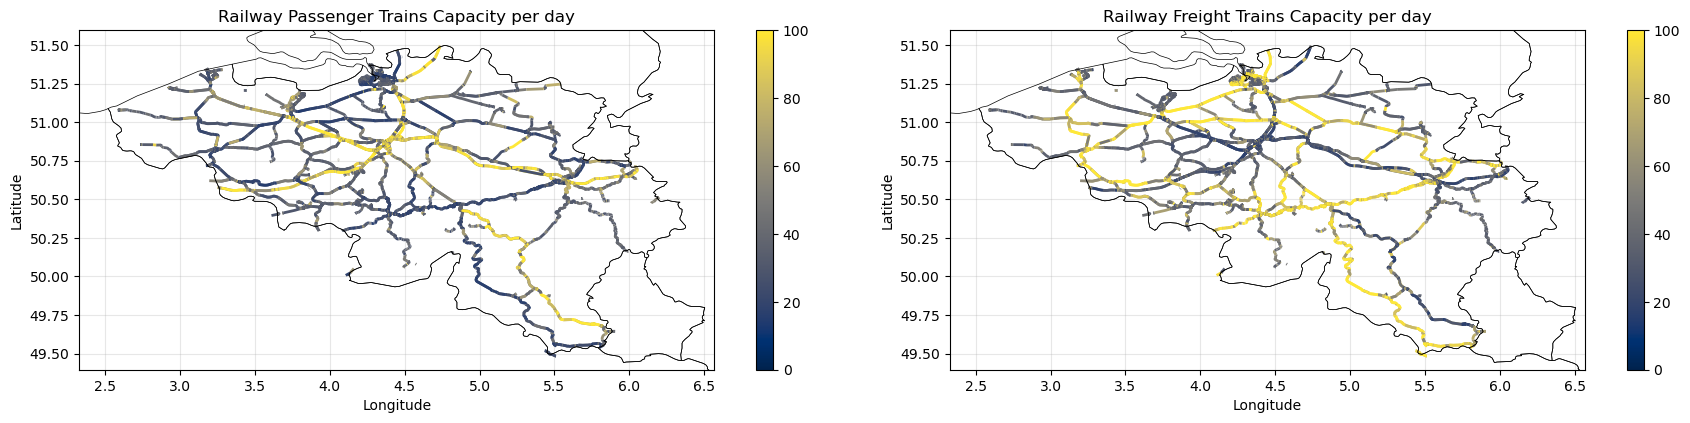

In [3]:
edges_gdf = edges_gdf.copy()
edges_gdf['edge_id'] = np.arange(len(edges_gdf), dtype=int)


network_df = pd.DataFrame({
    'from_node': edges_gdf[edge_src].astype(str).values,
    'to_node':   edges_gdf[edge_dst].astype(str).values,
    'edge_id':   edges_gdf['edge_id'].values,
    'travel_time': pd.to_numeric(edges_gdf['travel_time'], errors='coerce').fillna(1.0).astype(float).values,
    'CORRIDORS': edges_gdf['CORRIDORS'].values
})

network_df['trips'] = 0.0
network_df['ths_tons'] = 0.0
rng = np.random.default_rng(42)
train_draw_tons = np.maximum(rng.normal(700.0/1000, 35.0/1000, size=len(edges_gdf)), 0.0)
occ_draw_tons   = np.clip(rng.normal(0.90, 0.09, size=len(edges_gdf)), 0.0, 1.0)
eff_tons   = train_draw_tons * occ_draw_tons
cap_tons = compute_edge_capacity(edges_gdf, tt_col='travel_time', train_tons=eff_tons, mode='Freight')
cap_arr_tons = np.asarray(cap_tons, dtype=float)
cap_arr_tons = np.where(np.isfinite(cap_arr_tons), cap_arr_tons, 0.0)
network_df['capacity_ths_tons'] = cap_arr_tons

train_draw_pass = np.maximum(rng.normal(300.0, 15.0, size=len(edges_gdf)), 0.0)
occ_draw_pass   = np.clip(rng.normal(0.50, 0.05, size=len(edges_gdf)), 0.0, 1.0)
eff_pass   = train_draw_pass * occ_draw_pass
cap_pass = compute_edge_capacity(edges_gdf, tt_col='travel_time', train_tons=eff_pass, mode='Passenger')
cap_arr_pass = np.asarray(cap_pass, dtype=float)
cap_arr_pass = np.where(np.isfinite(cap_arr_pass), cap_arr_pass, 0.0)
network_df['capacity_pass'] = cap_arr_pass

# Plot the number of trains per edge based on cap_arr_pass / eff_pass and cap_arr_tons / eff_tons
num_trains_pass = np.where(eff_pass > 0, cap_arr_pass / eff_pass, 0)
num_trains_freight = np.where(eff_tons > 0, cap_arr_tons / eff_tons, 0)

fig, ax = plt.subplots(1, 2, figsize=(18, 4))

edges_gdf_copy = edges_gdf.copy()
edges_gdf_copy['num_trains_pass'] = num_trains_pass/300
edges_gdf_copy['num_trains_freight'] = num_trains_freight/300

# Get Belgium geometry and bounds
belgium_row = europe_countries[europe_countries['NAME'].str.lower() == 'belgium']
minx, miny, maxx, maxy = belgium_row.total_bounds
margin_x = (maxx - minx) * 0.05
margin_y = (maxy - miny) * 0.05
xlim = (minx - margin_x, maxx + margin_x)
ylim = (miny - margin_y, maxy + margin_y)

# Plot Passenger Trains
edges_gdf_copy.plot(ax=ax[0], column='num_trains_pass', cmap='cividis', linewidth=2, legend=True, vmin=0, vmax=100)
europe_countries.boundary.plot(ax=ax[0], color='black', linewidth=0.5)
ax[0].set_title('Railway Passenger Trains Capacity per day')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].grid(True, alpha=0.3)

# Plot Freight Trains
edges_gdf_copy.plot(ax=ax[1], column='num_trains_freight', cmap='cividis', linewidth=2, legend=True, vmin=0, vmax=100)
europe_countries.boundary.plot(ax=ax[1], color='black', linewidth=0.5)
ax[1].set_title('Railway Freight Trains Capacity per day')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Create network

- Estimate per-edge capacities (trains/day and passengers/day)
- Save capacity parquet and plot by rail class plus combined map

In [4]:
thr_capacity = 1
# Filter out edges with capacity below threshold
network_df_filtered = network_df[(network_df['capacity_ths_tons'] >= thr_capacity) & (network_df['capacity_pass'] >= thr_capacity)].copy()
edges_gdf_copy = edges_gdf[edges_gdf['edge_id'].isin(network_df_filtered['edge_id'])].copy()
edges_gdf_copy = edges_gdf_copy.merge(
    network_df_filtered[['edge_id', 'capacity_ths_tons', 'capacity_pass']],
    on='edge_id', how='left'
    )

base_graph = ig.Graph.TupleList(
    network_df_filtered[['from_node', 'to_node', 'edge_id', 'travel_time']].itertuples(index=False, name=None),
    edge_attrs=['edge_id', 'travel_time'],
    directed=False
)

print(f"Network: {base_graph.vcount()} nodes, {base_graph.ecount()} edges in igraph object.")

# total capacities
total_cap_freight = network_df_filtered['capacity_ths_tons'].sum()
total_cap_passenger = network_df_filtered['capacity_pass'].sum()
print(f"Total Freight Capacity (ths tons): {total_cap_freight:,.2f}")
print(f"Total Passenger Capacity: {total_cap_passenger:,.2f}")


Network: 26196 nodes, 30741 edges in igraph object.
Total Freight Capacity (ths tons): 343,659,613.69
Total Passenger Capacity: 67,087,462,445.50


## 5. Assign flows to the network

- Estimate per-edge capacities (trains/day and passengers/day)
- Save capacity parquet and plot by rail class plus combined map

In [5]:
# Prepare OD flows for allocation
flow_ods_pass = (od_pass[['from_node', 'to_node', 'trips']].groupby(['from_node', 'to_node'], as_index=False)['trips'].sum())
flow_ods_freight = (od_freight[['from_node', 'to_node', 'ths_tons']].groupby(['from_node', 'to_node'], as_index=False)['ths_tons'].sum())

# Run capacity-constrained allocation for passenger trains
capacity_ods_pass, unassigned_paths_pass, filtered_network_df, progress_df = od_flow_allocation_capacity_constrained(
    flow_ods=flow_ods_pass,
    network_dataframe=network_df_filtered,
    flow_column='trips',
    cost_column='travel_time',
    path_id_column='edge_id',
    attribute_list=None,
    origin_id_column='from_node',
    destination_id_column='to_node',
    network_capacity_column='capacity_pass',
    directed=False,
    simple=False,
    store_edge_path=True,
    graph_base=base_graph,
    track_progress=True,
    early_stop_share=0.95
)

# Run capacity-constrained allocation for freiht trains
capacity_ods_freight, unassigned_paths_freight, filtered_network_df, progress_df = od_flow_allocation_capacity_constrained(
    flow_ods=flow_ods_freight,
    network_dataframe=network_df_filtered,
    flow_column='ths_tons',
    cost_column='travel_time',
    path_id_column='edge_id',
    attribute_list=None,
    origin_id_column='from_node',
    destination_id_column='to_node',
    network_capacity_column='capacity_ths_tons',
    directed=False,
    simple=False,
    store_edge_path=True,
    graph_base=base_graph,
    track_progress=True,
    early_stop_share=0.95
)

# Aggregate assigned flows per edge
if isinstance(capacity_ods_pass, list):
    assigned_passenger_df = pd.concat(capacity_ods_pass, ignore_index=True)
else:
    assigned_passenger_df = capacity_ods_pass

if isinstance(capacity_ods_freight, list):
    assigned_freight_df = pd.concat(capacity_ods_freight, ignore_index=True)
else:
    assigned_freight_df = capacity_ods_freight

# Get total assigned trips per edge
assigned_passenger_on_edges = get_flow_on_edges(assigned_passenger_df, 'edge_id', 'edge_path', 'trips')
assigned_freight_on_edges = get_flow_on_edges(assigned_freight_df, 'edge_id', 'edge_path', 'ths_tons')

# Merge back into filtered_network_df
filtered_network_df = filtered_network_df.merge(
    assigned_passenger_on_edges.rename(columns={'trips': 'assigned_passenger_trips'}),
    on='edge_id', how='left'
)
filtered_network_df = filtered_network_df.merge(
    assigned_freight_on_edges.rename(columns={'ths_tons': 'assigned_ths_tons'}),
    on='edge_id', how='left'
)

# Fill NaN with 0 for assigned flows
filtered_network_df['assigned_passenger_trips'] = filtered_network_df['assigned_passenger_trips'].fillna(0.0)
filtered_network_df['assigned_ths_tons'] = filtered_network_df['assigned_ths_tons'].fillna(0.0)

# Ensure filtered_network_df has geometry
filtered_network_df = filtered_network_df.merge(
    edges_gdf[['edge_id', 'geometry']],
    on='edge_id',
    how='left'
)


[progress] iter=0 assigned_iter=100689267.000 cum=100689267.000 (0.8756) remaining=14309596.000 overcap_edges=0 next_flows=0
[progress] iter=0 assigned_iter=31656.771 cum=31656.771 (0.4609) remaining=37030.079 overcap_edges=0 next_flows=0


## 7. Create Flow Visualization

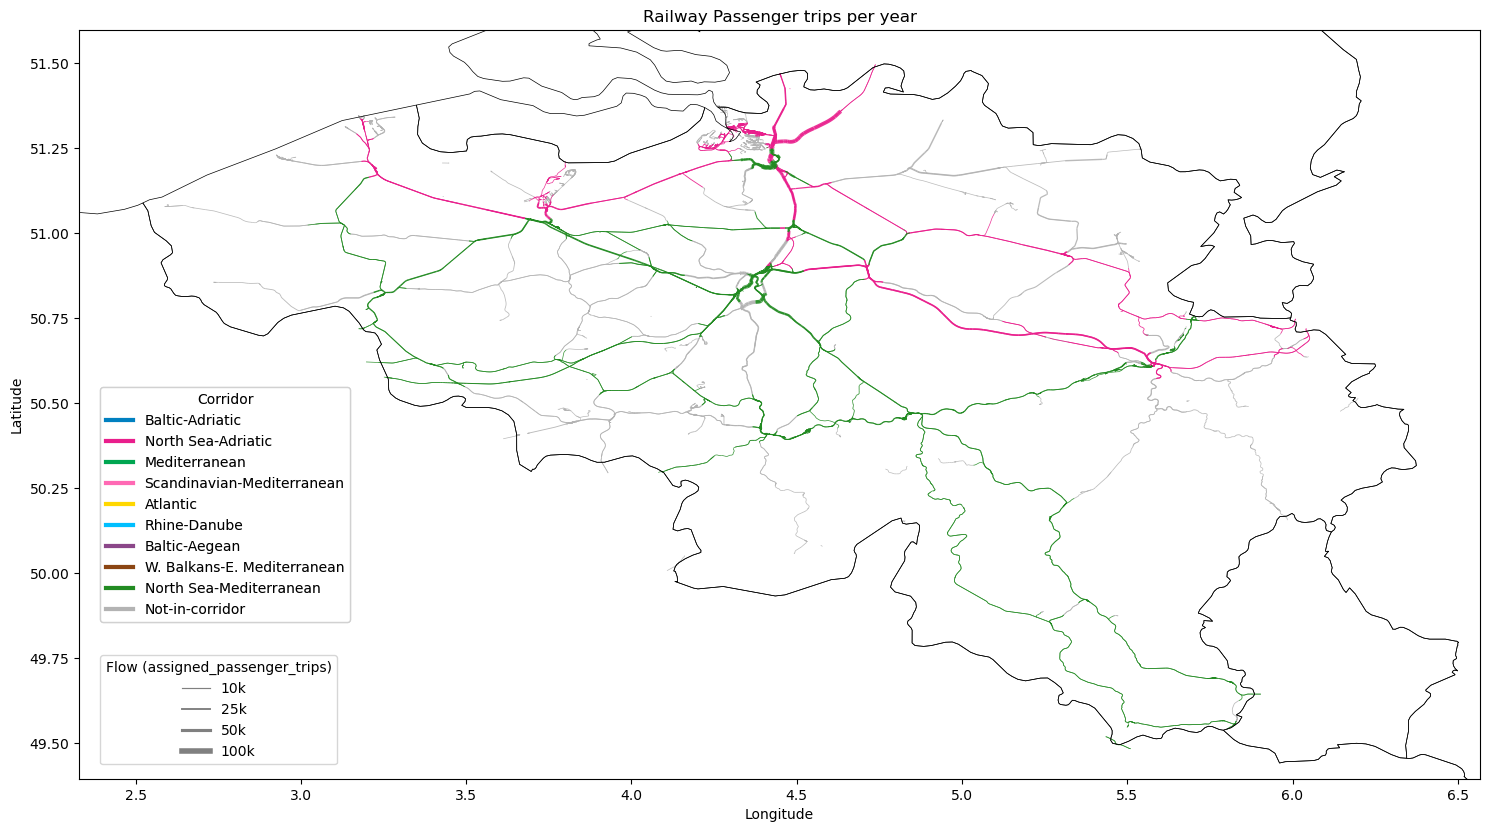

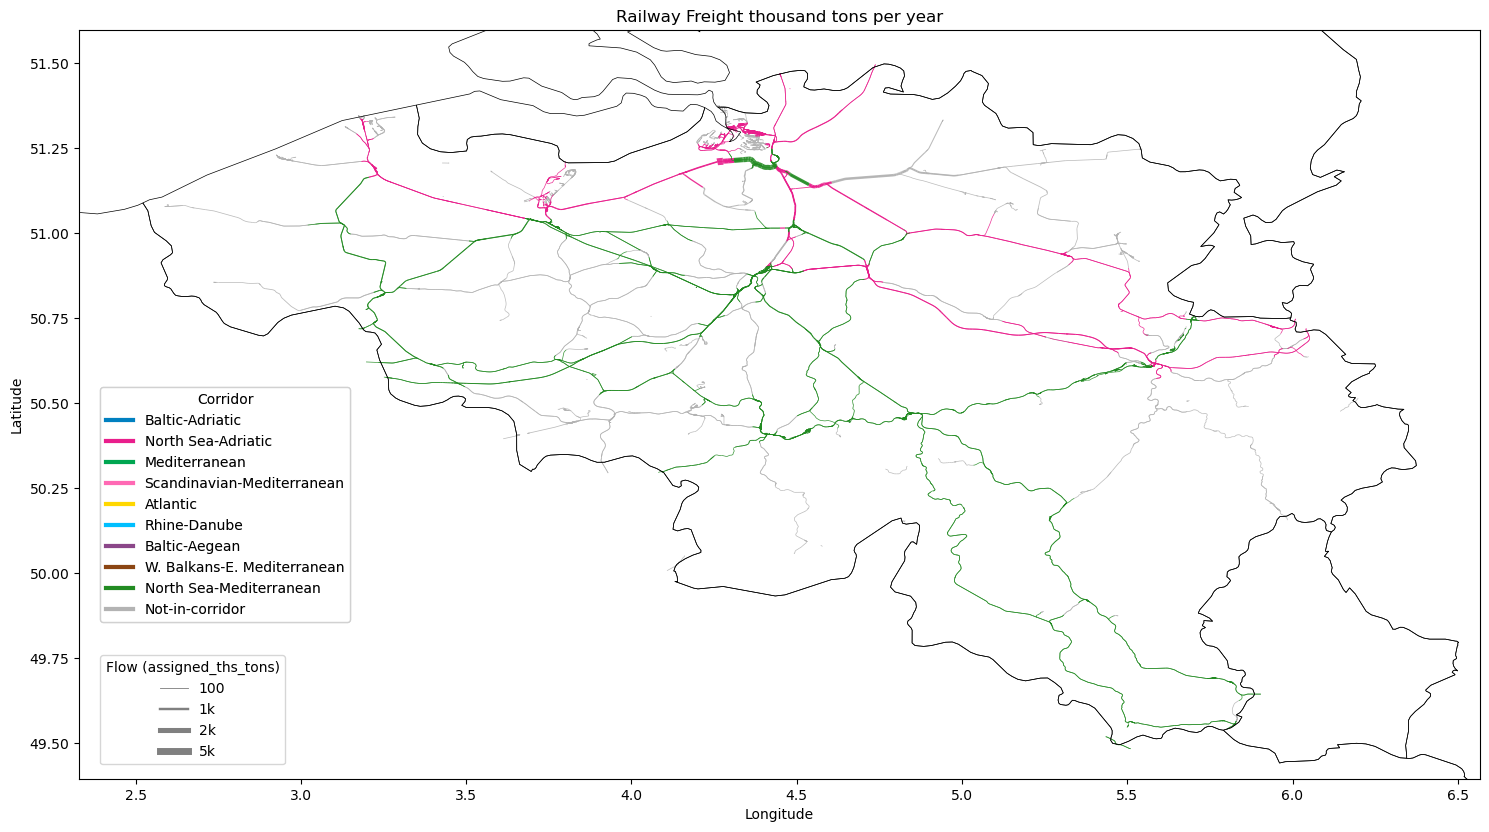

In [10]:
# Set the selected country
SELECTED_COUNTRY = "Belgium"

# Create figure
fig, ax1 = plt.subplots(1, 1, figsize=(15, 10))

plot_edges_by_flow_thickness(
    ax1,filtered_network_df, flow_col='assigned_passenger_trips', corridors_col='CORRIDORS',
    lw_min=0.5, lw_max=5, scale='linear', scale_div=100, legend_ticks=[10000,25000,50000,100000]
 )
europe_countries.boundary.plot(ax=ax1, color='black', linewidth=0.5)
ax1.set_title('Railway Passenger trips per year')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)

plt.savefig(outpath / f'rail_network_pass_{SELECTED_COUNTRY.replace(" ", "_")}_zoom.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(1, 1, figsize=(15, 10))

plot_edges_by_flow_thickness(
    ax2,filtered_network_df, flow_col='assigned_ths_tons', corridors_col='CORRIDORS',
    lw_min=0.5, lw_max=5, scale='linear', scale_div=5, legend_ticks=[100,1000,2500,5000]
 )
europe_countries.boundary.plot(ax=ax2, color='black', linewidth=0.5)
ax2.set_title('Railway Freight thousand tons per year')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)

plt.savefig(outpath / f'rail_network_freight_{SELECTED_COUNTRY.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [7]:
# --- Summary Statistics for Passengers and Freight ---
# Passenger OD summary
total_passenger_ods = len(od_pass)
total_passenger_trips = od_pass['trips'].sum()
# capacity_ods_pass is a list of DataFrames, so concatenate first if needed
if isinstance(capacity_ods_pass, list):
    assigned_passenger_df = pd.concat(capacity_ods_pass, ignore_index=True) if capacity_ods_pass else pd.DataFrame()
else:
    assigned_passenger_df = capacity_ods_pass if 'capacity_ods_pass' in locals() else pd.DataFrame()
assigned_passenger_trips = assigned_passenger_df['trips'].sum() if not assigned_passenger_df.empty else 0.0
max_passenger_edge_flow = assigned_passenger_df['trips'].max() if not assigned_passenger_df.empty else 0.0
min_passenger_edge_flow = assigned_passenger_df['trips'].min() if not assigned_passenger_df.empty else 0.0
mean_passenger_edge_flow = assigned_passenger_df['trips'].mean() if not assigned_passenger_df.empty else 0.0
unassigned_passenger_trips = None
if 'unassigned_paths_pass' in locals() and unassigned_paths_pass:
    unassigned_df_pass = pd.concat(unassigned_paths_pass, ignore_index=True)
    unassigned_passenger_trips = unassigned_df_pass['trips'].sum()
else:
    unassigned_passenger_trips = 0.0

print("="*80)
print("PASSENGER FLOW SUMMARY")
print("="*80)
print(f"Total OD pairs: {total_passenger_ods:,}")
print(f"Total trips: {total_passenger_trips:,.0f}")
# print(f"Assigned trips: {assigned_passenger_trips:,.0f}")
# print(f"Unassigned trips: {unassigned_passenger_trips:,.0f}")
print(f"Max edge flow (passenger): {max_passenger_edge_flow:,.0f}")
print(f"Mean edge flow (passenger): {mean_passenger_edge_flow:,.0f}")
# if total_passenger_trips > 0:
#     print(f"% Assigned: {100*assigned_passenger_trips/total_passenger_trips:.2f}%")
#     print(f"% Unassigned: {100*unassigned_passenger_trips/total_passenger_trips:.2f}%")
print()
# Freight OD summary
total_freight_ods = len(od_freight)
total_freight_tons = od_freight['ths_tons'].sum()

if 'capacity_ods_freight' in locals():
    if isinstance(capacity_ods_freight, list):
        assigned_freight_df = pd.concat(capacity_ods_freight, ignore_index=True) if capacity_ods_freight else pd.DataFrame()
    else:
        assigned_freight_df = capacity_ods_freight
    assigned_freight_tons = assigned_freight_df['ths_tons'].sum() if not assigned_freight_df.empty else 0.0
    max_freight_edge_flow = assigned_freight_df['ths_tons'].max() if not assigned_freight_df.empty else 0.0
    min_freight_edge_flow = assigned_freight_df['ths_tons'].min() if not assigned_freight_df.empty else 0.0
    mean_freight_edge_flow = assigned_freight_df['ths_tons'].mean() if not assigned_freight_df.empty else 0.0
else:
    assigned_freight_tons = None
    max_freight_edge_flow = None
    min_freight_edge_flow = None
    mean_freight_edge_flow = None
if 'unassigned_paths_freight' in locals() and unassigned_paths_freight:
    unassigned_df_freight = pd.concat(unassigned_paths_freight, ignore_index=True)
    unassigned_freight_tons = unassigned_df_freight['ths_tons'].sum()
else:
    unassigned_freight_tons = 0.0

print("="*80)
print("FREIGHT FLOW SUMMARY")
print("="*80)
print(f"Total OD pairs: {total_freight_ods:,}")
print(f"Total tons: {total_freight_tons:,.0f} ths tons")
# if assigned_freight_tons is not None:
#     print(f"Assigned tons: {assigned_freight_tons:,.0f} ths tons")
# if unassigned_freight_tons is not None:
#     print(f"Unassigned tons: {unassigned_freight_tons:,.0f} ths tons")
if max_freight_edge_flow is not None:
    print(f"Max edge flow (freight): {max_freight_edge_flow:,.0f} ths tons")
if mean_freight_edge_flow is not None:
    print(f"Mean edge flow (freight): {mean_freight_edge_flow:,.0f} ths tons")
# if total_freight_tons > 0 and assigned_freight_tons is not None:
#     print(f"% Assigned: {100*assigned_freight_tons/total_freight_tons:.2f}%")
# if total_freight_tons > 0 and unassigned_freight_tons is not None:
#     print(f"% Unassigned: {100*unassigned_freight_tons/total_freight_tons:.2f}%")
print("="*80)

PASSENGER FLOW SUMMARY
Total OD pairs: 45,484
Total trips: 114,998,863
Max edge flow (passenger): 1,026,446
Mean edge flow (passenger): 2,620

FREIGHT FLOW SUMMARY
Total OD pairs: 42,270
Total tons: 68,687 ths tons
Max edge flow (freight): 3,639 ths tons
Mean edge flow (freight): 3 ths tons
